## WhatsApp Group Chat Analysis

In [1]:
import re
import regex
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emoji
from os import path
import plotly.express as px
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
%matplotlib inline

In [2]:
# This function checks for message that starts with date and time as it is a new message!
def containsDateInfo(line):
    pattern = '^\[([0-9]+)([\/-])([0-9]+)([\/-])([0-9]+)[,]? ([0-9]+):([0-9][0-9]):([0-9][0-9])[ ]?(AM|PM|am|pm)?\]'
    result = re.match(pattern,line)
    if result:
        return True
    return False

In [3]:
containsDateInfo("[12:39:37 AM] You were added")

False

In [4]:
# Retrives date, time, author, message info from given string
def getAllInfo(line):
    info = line.split(']')
    datetime = info[0].split(',')
    date = datetime[0][1:]
    time = datetime[1].strip()
    authorMessage = info[1].split(':')
    if len(authorMessage) == 2:
        author = authorMessage[0].strip()
    else:
        author = None
    message = authorMessage[-1].strip()
    return date, time, author, message

In [5]:
date, time, author, message = getAllInfo("[2014-11-09, 12:39:37 AM] You were added")
print(date)
print(time)
print(author)
print(message)

2014-11-09
12:39:37 AM
None
You were added


In [27]:
data = []
with open('_chat.txt',encoding='utf-8') as f:
    f.readline()
    f.readline()
    f.readline()
    msgBuffer = []
    date, time, author = None, None, None
    while True:
        line = f.readline()
        if not line:
            break
        line = line.strip()
        line= (line.encode('ascii', 'ignore')).decode("utf-8") 
        if containsDateInfo(line):
            if len(msgBuffer) > 0:
                data.append([date, time, author, ' '.join(msgBuffer)])
            date, time, author, message = getAllInfo(line)
            msgBuffer.clear()
            msgBuffer.append(message)            
        else:
            
#             if containsDateInfo(line): 
#                 if len(msgBuffer) > 0:
#                     data.append([date, time, author, ' '.join(msgBuffer)])
#                 date, time, author, message = getAllInfo(line)
#                 msgBuffer.clear()
#                 msgBuffer.append(message)
#             else:
            msgBuffer.append(line)

In [28]:
#data[:5]

In [29]:
# let's create pandas dataframe
df = pd.DataFrame(data,columns=['date','time','author','message'])

In [30]:
df.date = pd.to_datetime(df.date,format='%Y-%m-%d')

In [31]:
df.date.dtype

dtype('<M8[ns]')

In [32]:
df.head()

,date,time,author,message
0,2019-12-28,12:02:09 PM,Daksha bhabhi,"*"" ""* . , , ..."
1,2019-12-30,11:58:02 AM,Pius Fuva,image omitted
2,2019-12-30,11:58:24 AM,Anjali,
3,2019-12-30,12:16:54 PM,Switu,Latabanu !!
4,2019-12-30,2:08:02 PM,Manthu,


### Group members' names

In [13]:
names = df.author.dropna().unique()

In [14]:
print(names)

['Daksha bhabhi' 'Pius Fuva' 'Anjali' 'Switu' 'Manthu' 'Sailesh Fuva'
 'Mohak Patel' 'Raj' 'Jay Bhai Kadi' 'Ravindra Fua' 'Ami Didi'
 'Shivam Jiju' 'Papa' 'Didi' 'Hasu Fai' 'V K Patel' 'Mummy']


In [15]:
print(f'Group consists of {len(names)} members')

Group consists of 17 members


In [16]:
df = df.dropna()

In [17]:
df

,date,time,author,message
0,2019-12-28,12:02:09 PM,Daksha bhabhi,"*"" ""* . , , ..."
1,2019-12-30,11:58:02 AM,Pius Fuva,image omitted
2,2019-12-30,11:58:24 AM,Anjali,
3,2019-12-30,12:16:54 PM,Switu,Latabanu !!
4,2019-12-30,2:08:02 PM,Manthu,
...,...,...,...,...
1976,2020-07-13,4:05:21 AM,Ravindra Fua,
1977,2020-07-13,11:41:27 AM,Sailesh Fuva,image omitted
1978,2020-07-13,11:25:31 PM,Ravindra Fua,image omitted
1979,2020-07-13,11:25:32 PM,Ravindra Fua,Good morning Jay Maa Umiya


### Author's stats

In [18]:
auth = df.author.value_counts()

In [19]:
type(auth)

pandas.core.series.Series

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

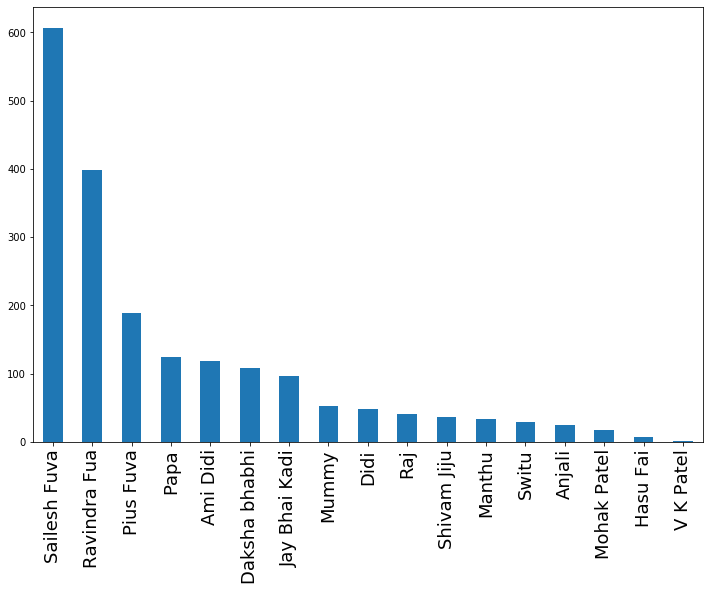

In [20]:
plt.figure(figsize=(12,8))
auth.plot.bar()
plt.xticks(fontsize=18)

Shailesh fua is the most active member of the group and Vasant fua is the least!

### Group stats

In [37]:
def extractHour(time):
    
    time = str(time)
    st = time.split(':')[0]
    if 'PM' in time:
        st = st + ' PM'
    else: st = st + ' AM'
    return st

In [38]:
df['hour'] = df.time.apply(extractHour)

In [39]:
most_active_hour = df.hour.value_counts()

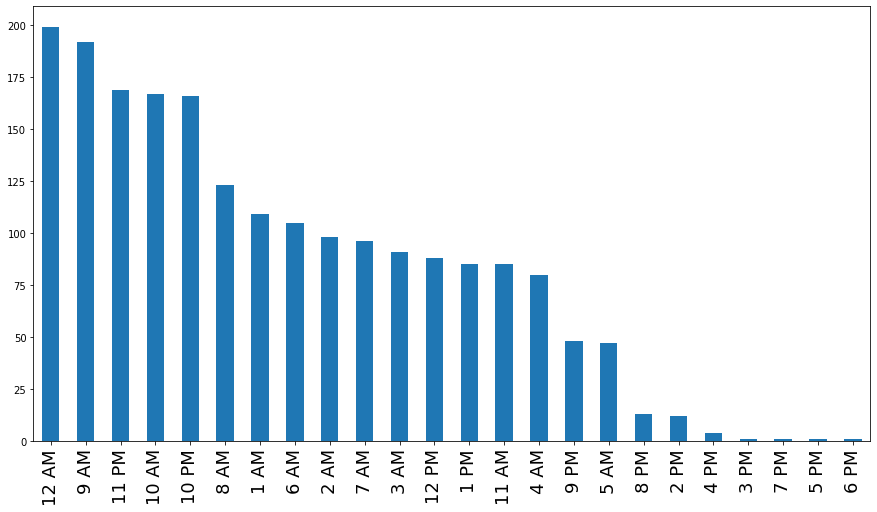

In [40]:
plt.figure(figsize=(15,8))
most_active_hour.plot.bar()
plt.xticks(fontsize=18);

Group is more active in late night!
Lockdown has affected the sleep routine of members!

### Let's analyse the most common words used by each group member

In [51]:
def updateMessage(msg):    
    if 'omitted' in msg or 'deleted' in msg:
#         print(msg)
        msg = ""
    return msg

In [52]:
df.message = df.message.apply(updateMessage)

               Author name:  Daksha bhabhi


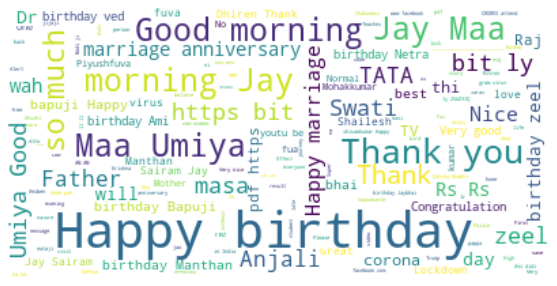





               Author name:  Pius Fuva


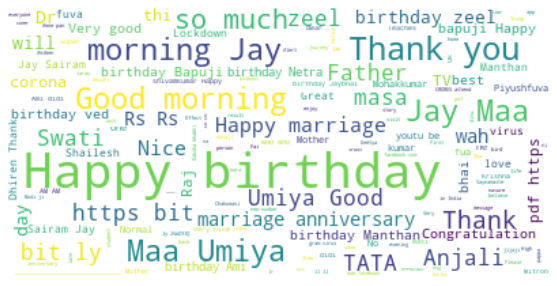





               Author name:  Anjali


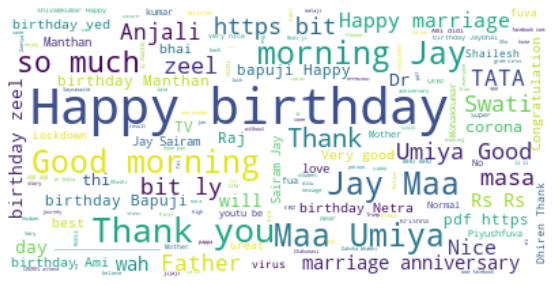





               Author name:  Switu


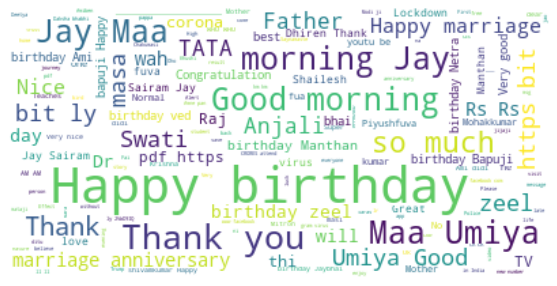





               Author name:  Manthu


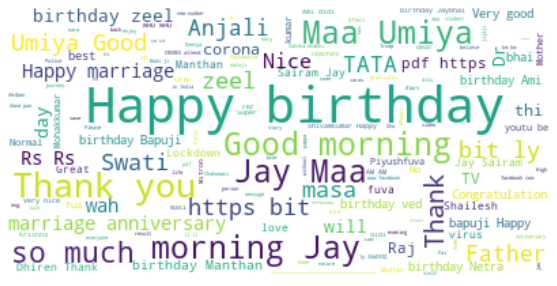





               Author name:  Sailesh Fuva


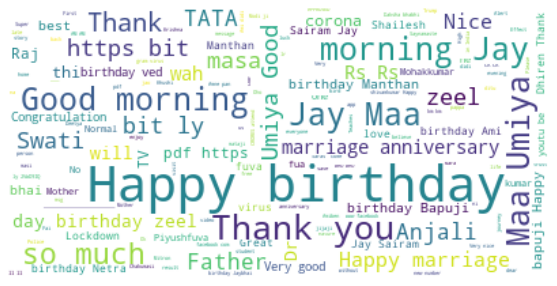





               Author name:  Mohak Patel


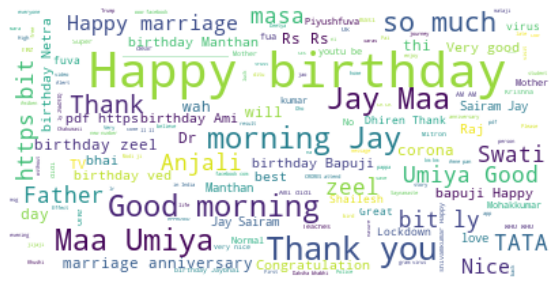





               Author name:  Raj


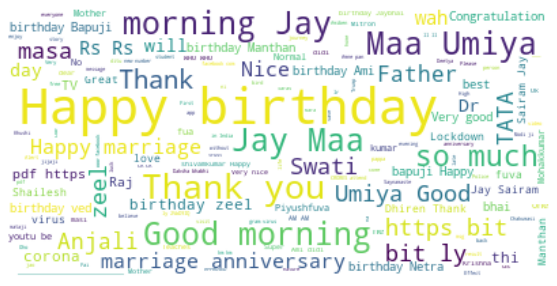





               Author name:  Jay Bhai Kadi


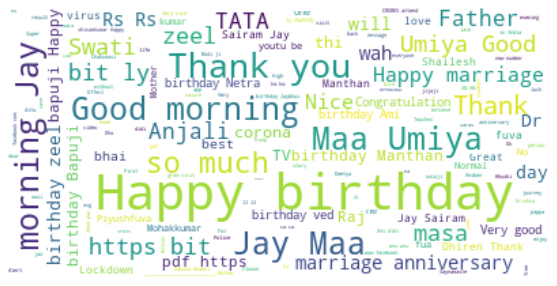





               Author name:  Ravindra Fua


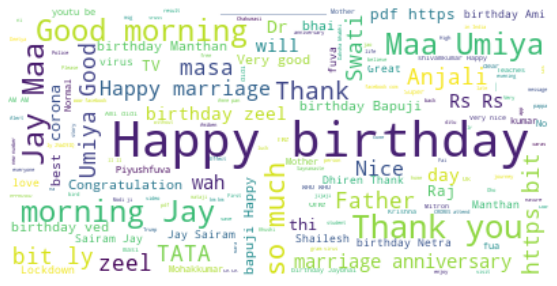





               Author name:  Ami Didi


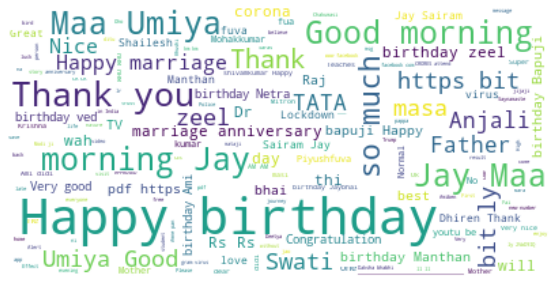





               Author name:  Shivam Jiju


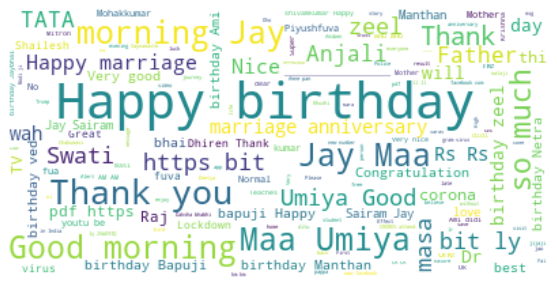





               Author name:  Papa


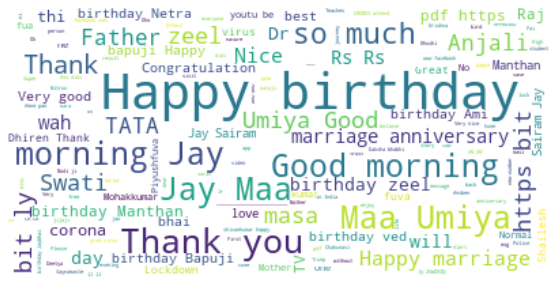





               Author name:  Didi


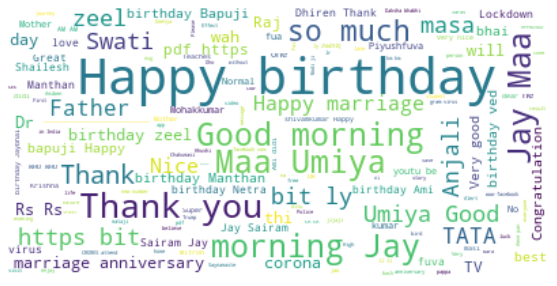





               Author name:  Hasu Fai


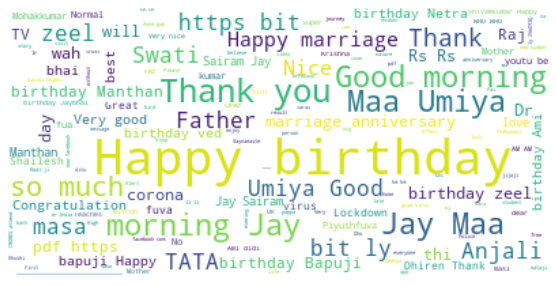





               Author name:  V K Patel


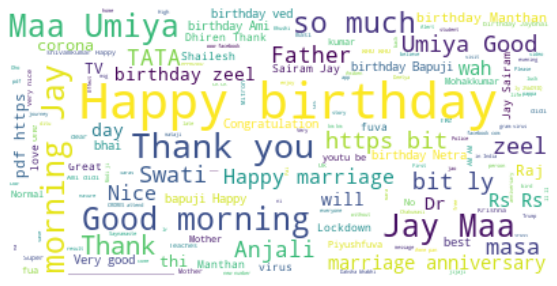





               Author name:  Mummy


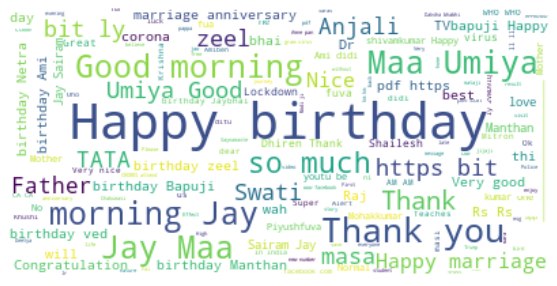

In [61]:
for i in range(len(names)):
    frame = df[df['author'] == names[i]]
    tex = " ".join(review for review in df.message)
    stopwords = set(STOPWORDS)
    #   stopwords.update(["ra", "ga", "na", "ani", "em", "ki", "ah","ha","anta","kuda","ante","la","eh","Nen","ne","haa","Haa","le"])
      # Generate a word cloud image
    print('============================================================')
    print('               Author name: ',names[i])
    print('============================================================')
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
      # Display the generated image:
      # the matplotlib way:

    plt.figure( figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    print('\n\n\n')
    